In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
#os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')
from tqdm.autonotebook import tqdm

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns
import itertools

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/gut/'

In [3]:
models = {
    'Cell2location' : f'{results_folder}c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_alphatest20/',
    'No w_sf factorisation' : f'{results_folder}c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_no_factorisation_alphatest20/',
    #'No m_g' : f'{results_folder}c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_no_mg_alphatest20/',
    'No NB regression' : f'{results_folder}c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_noNB_alphatest20/'
}

In [4]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd


import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

# Set paths to data and results used through the document:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/gut_kj_re/oxford_visium/'
annotations_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/tissue_annotation/oxford/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/gut/'

regression_model_output = 'v1_ye_signatures_lr0002_Adam'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'
## snRNAseq reference (raw counts)
adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

run_name = 'c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_alphatest20'
scvi_run_name = f'{results_folder}/{run_name}'

# path for saving figures
fig_path = f'{results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

In [5]:
reg_path


'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/gut/regression_model/v1_ye_signatures_lr0002_Adam/'

In [6]:
# region annotations for each cell type
gold_standard_dict = {
    'Cycling B cell': 'Lymphoid_structure',
    'Naive B': 'Lymphoid_structure',
    'SELL+ CD8 T': 'Lymphoid_structure',
    'SELL+ CD4 T': 'Lymphoid_structure',
    'Treg': 'Lymphoid_structure',
    'T reticular': 'Lymphoid_structure',
    'cDC2': 'Lymphoid_structure',
    'cDC1': 'Lymphoid_structure',
    'Lymphoid DC': 'Lymphoid_structure',
    'DZ GC cell': 'Lymphoid_structure',
    'Tfh': 'Lymphoid_structure',
    'GC B cell': 'Lymphoid_structure',
    'FDC': 'Lymphoid_structure',
    'LZ GC cell': 'Lymphoid_structure',
    'STAT1+ Naive B': 'Lymphoid_structure',
    'FCRL4+ Memory B': 'Lymphoid_structure',
    'Memory B': 'Lymphoid_structure',
    'Activated CD4 T': 'Lymphoid_structure',
    'CD8 Tmem': 'Lymphoid_structure',
} 

gold_standard = pd.DataFrame(gold_standard_dict, index=['label']).T
gold_standard.index = [f'gold_standard_{i}' for i in gold_standard.index]

for ct in gold_standard.index:
    adata_vis.obs[ct] = adata_vis.obs['Annotation'].isin([gold_standard.loc[ct, 'label']]).astype(float)
    
adata_vis.obs[gold_standard.index]

from re import sub
col_ind = [sub('gold_standard_','',i) for i in gold_standard.index]

pos_cell_count = adata_vis.obs[gold_standard.index].values
pos_cell_count_df = adata_vis.obs[gold_standard.index]

In [7]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']

In [8]:
from scipy.spatial.distance import cdist

ct_dist = cdist(inf_aver.T, inf_aver.T, metric='euclidean')
ct_dist = pd.DataFrame(ct_dist, index=inf_aver.columns, columns=inf_aver.columns)


distinctiveness = pd.DataFrame(np.array(
    [[ct_dist[c].sort_values()[1:4].mean() for c in ct_dist.columns],
     [ct_dist[c].sort_values()[1].mean() for c in ct_dist.columns]]
).T,
             index=ct_dist.columns, columns=['top3_average_distance', 'min_distance'])

distinctiveness['min_distance'][gold_standard_dict.keys()].sort_values(),\
distinctiveness['min_distance'].sort_values()

design = distinctiveness.loc[col_ind,:]

In [9]:
design['is_high_density'] = 0
design.loc[design.index.isin([
    'Cycling B cell',
    'Naive B',
    'SELL+ CD8 T',
    'SELL+ CD4 T',
    'DZ GC cell',
    'GC B cell',
    'LZ GC cell'
]), 'is_high_density'] = 1

design['is_txn_fine'] = 1-np.digitize(design['min_distance'].values,
                                      [100]
                                      #np.histogram(distinctiveness['min_distance'].values, bins=4)[1]
                                     )

In [10]:
from re import sub

results = []
names = list(models.keys())

for name in names:
    
    sp_data_file = models[name] + '/sp.h5ad'
    adata_vis_res = anndata.read(sp_data_file)

    spot_factors = adata_vis_res.obsm['q05_cell_abundance_w_sf']
    spot_factors.columns = adata_vis_res.uns['mod']['factor_names']
    
    infer_cell_proportions = (spot_factors.T / spot_factors.sum(1)).T
    infer_cell_proportions = infer_cell_proportions.fillna(0)

    infer_cell_count = spot_factors[col_ind]
    infer_cell_proportions = infer_cell_proportions[col_ind]

    results.append(infer_cell_proportions)
    #results.append(infer_cell_count)

In [11]:
results_folder_st = f'{results_folder}oxford/rctd/'
RCTD = pd.read_csv(f'{results_folder_st}results_selected_weights_76clusters.csv',
                   index_col='spot')
adata_vis_res = adata_vis_res[adata_vis_res.obs_names.isin(RCTD.index),:]

# compute cell proportions
RCTD = (RCTD.T / RCTD.sum(1)).T
RCTD = RCTD.loc[adata_vis_res.obs_names,:]
RCTD = RCTD.fillna(0)

adata_vis_res.obs[[f'RCTD_{i}' for i in RCTD.columns]] = RCTD.values

results = results + [RCTD[col_ind]]
names = names + ['RCTD']

Trying to set attribute `.obs` of view, copying.


In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from scipy import interpolate

from functools import partial
from itertools import cycle

def swap_return_order(f, order, *args, **kwargs):
    result = f(*args, **kwargs)
    return [result[i] for i in order]


with plt.style.context('seaborn'):
    seaborn_colors = mpl.rcParams['axes.prop_cycle'].by_key()['color']



def compute_curve(pos_cell_count, infer_cell_proportions, mode='macro', curve='AUC'):
    r"""
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, infer_cell_proportions.shape)
    
    X = dict()
    Y = dict()
    scores = dict()
    
    if curve == 'ROC':
        # in this case X is FPR and Y is TPR
        curve_function = partial(swap_return_order, roc_curve, [1, 0, 2])
        score_function = roc_auc_score
        
    elif curve == 'PR':
        # in this case X is recall and Y is precision
        curve_function = precision_recall_curve
        score_function = average_precision_score
        
    for i, c in enumerate(infer_cell_proportions.columns):
        Y[c], X[c], _ = curve_function(pos_cell_count[:, i], predictor[:, i])
        scores[c] = score_function(pos_cell_count[:, i], predictor[:, i], average=mode)

    scores["averaged"] = score_function(pos_cell_count, predictor, average=mode)
    
    if mode == 'micro':
        Y["averaged"], X["averaged"], _ = curve_function(pos_cell_count.ravel(), predictor.ravel())

    elif mode == 'macro':
        Ys = []
        x_grid = np.linspace(0, 1, 2000)
        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(X[c], Y[c])
            y_interp = f(x_grid)
            Ys.append(y_interp)

        X["averaged"] = x_grid
        Y['averaged'] = np.mean(Ys, axis=0)
    return X, Y, scores 

compute_roc = partial(compute_curve, curve='ROC')
compute_precision_recall = partial(compute_curve, curve='PR')

In [13]:
def calculate_r2(cell_count, infer_cell_count):
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    return cor


def calculate_rmse(cell_count, infer_cell_count):
    rmse = np.round(np.linalg.norm(cell_count.values.flatten() - infer_cell_count.values.flatten()), 3)
    return rmse


def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        patch.set_x(patch.get_x() + shrink * (round(patch.get_x()) - patch.get_x()) - shift)

def show_values_on_bars(axs, text_size=9):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.01
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", size=text_size) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

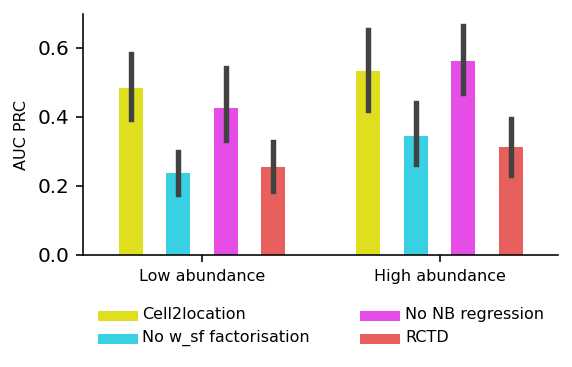

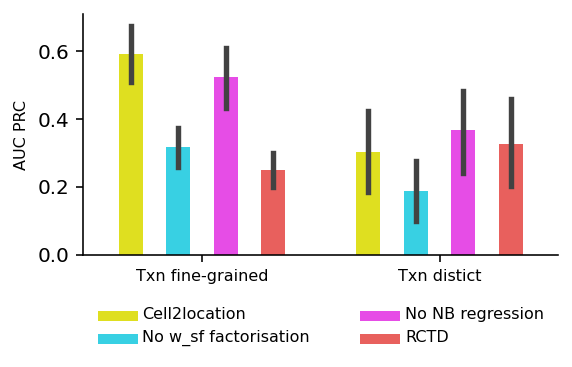

In [18]:
def remove_avg(d):
    d.pop('averaged')
    return d

def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch, line in zip(ax.patches, ax.lines) :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        x_orig = patch.get_x()
        patch.set_x(x_orig + diff * .5)
        x_orig = patch.get_x()
        patch.set_x(x_orig + shrink * (round(x_orig) - x_orig))
        
        line.set_xdata(line.get_xdata() + shrink * (np.round(x_orig) - x_orig))

get_PR_values = lambda x, y: list(remove_avg(compute_precision_recall(x.values, y, mode='macro')[2]).values())

dfs_detailed = []
for df, method in zip(results, names):
    df_detailed = pd.DataFrame({'value': get_PR_values(pos_cell_count_df.loc[df.index,[f'gold_standard_{i}' for i in df.columns]], df)})
    df_detailed['cell_type'] = df.columns
    df_detailed['is_high_density'] = design['is_high_density'][df.columns].values
    df_detailed['is_txn_fine'] = design['is_txn_fine'][df.columns].values
    df_detailed['min_distance'] = design['min_distance'][df.columns].values
    df_detailed = df_detailed.loc[df_detailed['min_distance'].sort_values().index,:]
    df_detailed['method'] = method
    
    dfs_detailed.append(df_detailed)
pr_data_values = pd.concat(dfs_detailed)

pr_data_values['Fig5_abundance_categories'] = ''
pr_data_values.loc[pr_data_values['is_high_density'] == 0, 'Fig5_abundance_categories'] = \
'Low abundance'
pr_data_values.loc[pr_data_values['is_high_density'] == 1, 'Fig5_abundance_categories'] = \
'High abundance'
pr_data_values['Fig5_abundance_categories'] = pr_data_values['Fig5_abundance_categories'].astype('category')
pr_data_values['Fig5_abundance_categories'] = pr_data_values['Fig5_abundance_categories'].cat.reorder_categories([
    'Low abundance', 'High abundance'
])

pr_data_values['Fig5_txn_categories'] = ''
pr_data_values.loc[pr_data_values['is_txn_fine'] == 1, 'Fig5_txn_categories'] = \
'Txn fine-grained'
pr_data_values.loc[pr_data_values['is_txn_fine'] == 0, 'Fig5_txn_categories'] = \
'Txn distict'
pr_data_values['Fig5_txn_categories'] = pr_data_values['Fig5_txn_categories'].astype('category')
pr_data_values['Fig5_txn_categories'] = pr_data_values['Fig5_txn_categories'].cat.reorder_categories([
    'Txn fine-grained', 'Txn distict'
])

def plot_boxplot_prc(x, y="value", n_leged_col=6):
    #g = sns.boxplot(x=x, y=y,
    #                hue="method",
    #                data=pr_data_values, palette=sc.pl.palettes.default_102);
    g = sns.barplot(x=x, y=y,
                    hue="method", ci=68,
                    data=pr_data_values, palette=sc.pl.palettes.default_102);
    
    change_width(g, .10)
    #change_width(g, .04, shrink=0.55, shift=0.01)
    
    plt.xlabel('');
    plt.ylabel('AUC PRC', size=8);
    plt.xticks(size=8, ha='center');
    # lgnd = plt.legend(loc='center left', bbox_to_anchor=(1.04, 0.5), ncol=1, 
    #            fontsize=15, frameon=False);

    lgnd = plt.legend(loc='center', bbox_to_anchor=(0, -0.45,  1, 0.3), 
                      mode='expand', ncol=n_leged_col, 
                      fontsize=8, frameon=False);

    for handle in lgnd.legendHandles:
         handle.set_height(5)
         handle.set_width(20)
         handle.set_y(-1)
    # plt.tight_layout();

    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    plt.tight_layout();

    # ax = plt.gca()
    # ax.set_xticks(ax.get_xticks() + 0.4)
    # plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')
    
plt.figure(figsize=(4.1, 2.8))
plot_boxplot_prc('Fig5_abundance_categories', n_leged_col=2)
plt.savefig(fig_path + '/barplot_FigS25_abundance_categories.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4.1, 2.8))
plot_boxplot_prc('Fig5_txn_categories', n_leged_col=2)
plt.savefig(fig_path + '/barplot_FigS25_txn_categories.pdf', bbox_inches='tight')
plt.show()

In [15]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/gut/c2l_v3_nonamortised_fulldata_epochs20k_lr0002_Adam_oxford_adult_paed_ref_signatures_N25_alphatest20/plots/figures/'